Artificial Intelligence: Deep Learning - 21/11-2022

#Histopathologic Cancer Detection using CNN


## Table of contents:
### [1. Case introduction](#case)
### [1.1 Dataset conciderations](#data)
### [1.2 The chosen dataset](#data2)
### [1.3 Examples of the microscopic images taken in the scans](#example)
### [2. Acessing dataset from Google Drive](#acess)
### [3. Implementation](#implementation)
### [3.1 Data preprocessing](#data3)
### [3.2 Constructing the networks](#network)
### [4. Results](#results)
### [5. Discussion](#disc)
### [6. Conclusion](#disc)

## 1. Case introduction <a id='case'></a>


The goal of this mini project is to develop a machine learning model capable of identifying cancer in patches of microscopic images taken from various large pathology scans. The images provided for this task are 96x96 pixels large. The interesting patch is the 32x32 pixel center of each image as described on Kaggle.  

[https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview][1]

This dataset in slightly modified version of the original available on [https://github.com/basveeling/pcam][2]

The only difference is that all duplicated are removed.


The problem is a binary classification problem which we intend to solve by leveraging Convolutional Neural Networks(CNN).

### 1.1 Dataset considerations  <a id='data'></a>
Based on what we learned in the course, the study cases, and our book (François Chollet - Deep Learning with Python), we turned our attention to image datasets and classification networks.

Kaggle provides many such datasets, we quickly found some interesting image-based datasets, however many seemed incomplete or difficult to use (too big or too small datasets, messy data, etc...). Some were also discarded because we aimed for a project that could be useful in a real-world context.

After some exploration, we settled on a dataset containing images of histopathological cancer.

It fulfilled our criteria, not too large in order to facilitate handling (we intended to use Google Colab in order to run our code, so the training data was to be uploaded to google drive). It was also quite well documented and straightforward to use. The medical context of the dataset also meant the project could be applied to a real-world problem, I.e. the correct identification of cancerous tissue.

### 1.2 The chosen dataset  <a id='data2'></a>
Kaggle provided us with a set of training images, and validation images. The images were scans of lymph node sections, and either contained cancerous tissue, or did not contain any cancerous tissue.

The dataset was composed of around 277485 images in .tif format, for a total of approximately 7.76 gigabytes. Each image was 96 by 96 pixels, however, the kaggle documentation states that the label is based on whether cancerous tissue is visible within the center of the images (approximately 32 pixels). Thus, we had to incorporate this information into our data preparation. It is not described why they choose to label the images like this.

Upon downloading the dataset, we realized the validation data provided by Kaggle contained exclusively negative samples. This led us to discard the validation data entirely and construct a new set of validation images (keeping a 75-25 split and randomly picking them from the training set).  This was not too difficult as we already needed to balance the dataset since the training images contained more negative samples than positive ones.

The remaining challenge is to crop or zoom the images to only study the center. As mentioned above, the labels are based on whether the sample contains cancerous tissue in a 32 by 32 pixel square at the center. The documentation for such an operation through Keras has proven difficult to understand, and even harder to verify if it has been cropped correctly.

### 1.3 Examples of the microscopic images taken in the scans <a id='example'></a>
Code the displaying the images can be found:
https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/



Text(0.5, 1.0, 'Positive')

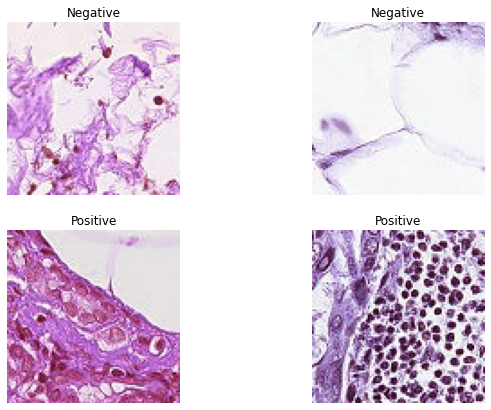

In [ ]:
# code for displaying multiple images in one figure
#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

# reading images
Image1 = cv2.imread('/content/new_test_unzip/data_unzip/new_test/0/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
Image2 = cv2.imread('/content/new_test_unzip/data_unzip/new_test/0/00011545a495817817c6943583b294c900a137b8.tif')
Image3 = cv2.imread('/content/new_test_unzip/data_unzip/new_test/1/00014e39b5df5f80df56f18a0a049d1cc6de430a.tif')
Image4 = cv2.imread('/content/new_test_unzip/data_unzip/new_test/1/00027298de60883932506d5c46be978d71a2da68.tif')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Negative")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Negative")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Positive")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Positive")

## Acessing dataset from Google Drive <a id ='acess'></a>

As we are using Google Collab, a few steps must be taken before we can acess the data. These are prerequsites in order for the notebook to run properly.
First step is to put the ZIP file from Kaggle as referencen earlier in the root directory of your Google Drive.
When the data is stored properly the Drive can be mounted to Collab project.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Google Collab now has acess to the drive and all the data can be unzipped and a path variable inizialised.

In [ ]:
!unzip "./drive/MyDrive/histopathologic-cancer-detection.zip" -d "data_unzip"

path = "./data_unzip/"

In [ ]:
#Cell for reproducing without rebalancing everything
!unzip "./drive/MyDrive/new_train.zip" -d "new_train_unzip"
!unzip "./drive/MyDrive/new_test.zip" -d "new_test_unzip"

train_path = "./new_train_unzip/data_unzip/new_train/"
test_path = "./new_test_unzip/data_unzip/new_test"


## Implementation

### Data preprocessing
Before we are able to train a model. We must prepare the data and make it suitable for training.

####Balancing
As mentioned in section 1, we have decided to discard the provided test folder as they are all negative examples. Checking the training set for balance.

In [ ]:
import csv
import pandas as pd
df = pd.read_csv(path + "train_labels.csv")
# The column containing the class variable is called label in the dataset.(0 for negative, 1 for positve.)
df["label"].value_counts()

0    130908
1     89117
Name: label, dtype: int64

It is apparent that we do in fact have an imbalanced dataset with a 60/40 distribution towards negatives.
The next step is to balance our dataset, to do so we have decided to down sample by deleting negative entries.  

In [ ]:
from sklearn.utils import resample

df_negative = df[df.label==0]
df_positive = df[df.label==1]

# Downsample majority class
df_negative_downsampled = resample(df_negative, replace=False, n_samples=df["label"].value_counts()[1], random_state=123)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_negative_downsampled, df_positive])

# Display new class counts
df_downsampled.label.value_counts()
print(df_downsampled.label.value_counts())


df_downsampled.to_csv(path + "balanced_labels.csv")


0    89117
1    89117
Name: label, dtype: int64


The balancing leaves us with 178234 entries evenly split between the two classes.

#### Split our data into training and test data
The remaining data is then split into two subsets; training- and validation set with a 75-25 percent distribution.

At the moment all the images from the original training split are located in the same folder. We want to have two new folders, one for each of the two new subsets containing images corresponding to the random split.

We did this by looping through every file in the directory and checking if the file belongs in the training set, if so, copy the image into the new folder, otherwise copy it into the test folder.

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import os

data_frame = pd.read_csv(path + "balanced_labels.csv")

training, validation = train_test_split(data_frame, train_size=.75, random_state=123)

# print(training)
# print(validation)

old_train_dir = path + "train"
old_test_dir = path + "test"

new_train_dir = path + "new_train"
new_test_dir = path + "new_test"

if (os.path.isdir(new_train_dir) == True):
  os.rmdir(new_train_dir)
os.mkdir(new_train_dir)
os.mkdir(new_train_dir + "/1")
os.mkdir(new_train_dir + "/0")

if (os.path.isdir(new_test_dir) == True):
  os.rmdir(new_test_dir)

os.mkdir(new_test_dir)
os.mkdir(new_test_dir + "/1")
os.mkdir(new_test_dir + "/0")

# print(training)
# print(type(training))

for filename in os.listdir(old_train_dir):
  fileId = filename.split(".")[0]

  if (fileId in training.id.values):
    index = training.loc[training.id == fileId]
    label = str(index.label.values[0])
   # print(label)

    shutil.copy(old_train_dir + "/" + filename, os.path.join(new_train_dir, label, filename))

  elif (fileId in validation.id.values):
    index = validation.loc[validation.id == fileId]
    label = str(index.label.values[0])
   # print(label)

    shutil.copy(old_train_dir + "/" + filename, os.path.join(new_test_dir, label, filename))


for filename in os.listdir(old_test_dir):
  fileId = filename.split(".")[0]


  if (fileId in validation.id.values):
    index = validation.loc[validation.id == fileId]
    label = str(index.label.values[0])
    #print(label)

    shutil.copy(old_test_dir + "/" + filename, os.path.join(new_test_dir, label, filename))



In [ ]:
## Only to be run to save new folders for reproduction
!zip -r new_test.zip ./data_unzip/new_test

#### Data augmentation
 As described in tensorflow's documentation [https://www.tensorflow.org/tutorials/images/data_augmentation][4]. Data augmentation is a technique to increase the amount of training data by adding additional data which is a slight modified version of the original.
We perform this augmentation using keras-built in ImageDataGenerator.

In [ ]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
IMAGESIZE = 96


training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True)

training_generator = training_data_generator.flow_from_directory(train_path,
                                                                 target_size=(32, 32),
                                                                 batch_size=192,
                                                                 class_mode='binary')

test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(test_path,
                                                          target_size=(32, 32),
                                                          batch_size=192,
                                                          class_mode='binary')


Found 133675 images belonging to 2 classes.
Found 44559 images belonging to 2 classes.


### Constructing the networks <a id='networks'></a>
Given our choice of dataset, a convolutional neural network seemed most relevant. Convolutional neural networks work particularly well with image classification and computer vision. This is thanks to a process called convolution in which the network moves over an image in strides of a few pixels at a time, constructing an output matrix from the input. Convolution allows better identification of specific features.


Based on our case study in cats and dogs classification, in order to train the model adequately we knew we should have at least two convolutional layers. We knew our input would be 32 pixels x 32 pixels, so we incorporated that into our input shape.
We have created three different neural networks which all contain at least two convolutional layers, with a flattening layer to normalize the input, and a dropout layer.

All networks uses relu acivation function all the way though the network and the sigmoid activation function for the output layer.

#### 1. network
The first network is exaclty as described above.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#### 2. Network
The second network is more complex than the first, due to additional layers. It has another dropout layer meant to decrease the amount of parameters, and an additional convolutional layer.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)


x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#### 3. model
The third network is very similar to the second one, but only has one dropout layer.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Initialize training

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="test_callbacks.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    training_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks)


Epoch 1/10
697/697 [==============================] - 147s 151ms/step - loss: 0.5278 - accuracy: 0.7432 - val_loss: 0.4763 - val_accuracy: 0.7775
Epoch 2/10
697/697 [==============================] - 106s 152ms/step - loss: 0.4767 - accuracy: 0.7794 - val_loss: 0.4987 - val_accuracy: 0.7713
Epoch 3/10
697/697 [==============================] - 104s 150ms/step - loss: 0.4541 - accuracy: 0.7919 - val_loss: 0.4139 - val_accuracy: 0.8138
Epoch 4/10
697/697 [==============================] - 105s 151ms/step - loss: 0.4353 - accuracy: 0.8016 - val_loss: 0.4080 - val_accuracy: 0.8184
Epoch 5/10
697/697 [==============================] - 106s 152ms/step - loss: 0.4244 - accuracy: 0.8071 - val_loss: 0.4885 - val_accuracy: 0.7671
Epoch 6/10
697/697 [==============================] - 107s 153ms/step - loss: 0.4141 - accuracy: 0.8130 - val_loss: 0.4577 - val_accuracy: 0.7837
Epoch 7/10
697/697 [==============================] - 103s 148ms/step - loss: 0.4062 - accuracy: 0.8172 - val_loss: 0.3910 -

## results
The code for making the shown in next section. It is based on our case study from cats and dogs classification. We have also taken some elements from chapter 4, "Getting started with neural networks", to showcase our results.

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("3. model: Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("3. model: Training and validation loss")
plt.legend()
plt.savefig('3model.jpg')
plt.show()

Text(0.5, 1.0, '3. Model')

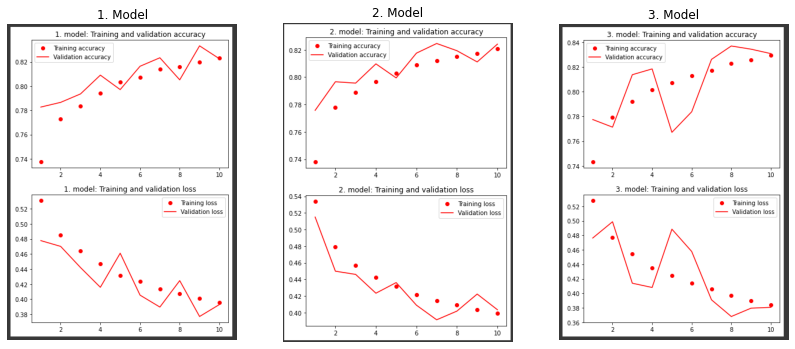

In [ ]:
# Reference : https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/
# code for displaying multiple images in one figure
#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(14, 12))

# setting values to rows and column variables
rows = 1
columns = 3

# reading images
Image1 = cv2.imread('/content/model1.PNG')
Image2 = cv2.imread('/content/model2.PNG')
Image3 = cv2.imread('/content/model3.PNG')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("1. Model")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("2. Model")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("3. Model")

As seen on the figure above all three models has almost the same accuracy, around 80-83%.
However looking at the traning and validation loss graphs, we can see some differences. The first and most simple network fluctuates a lot between whether or not validation or training loss is highest. Indicating that the model tends to overfit to the traning data and meaning that the model has trouble predicting data it has never seen.
The second model, which has an additional dropout layer. Performs quite well in terms of overfitting.
The last more complex model, seems to overfit a lot.

## Discussion

The different models perform decent in terms of accuracy, however is a real life envirmorment, in the context of detection wether or not a person has cancer a higher accuracy is desired, especially if the model has a high false negative rate. (Which we don't acually know, we had a hard time computing the metrics in our code).
There are various methods the models performance maybe could have been improved. We conducted very limited hyperparameter tuning, we have not experiment with the batch size, number of epochs, activation functions and so forth. A tuning of all of those parameters might have increased the performance.  
Another problem could be that how the images are labled, fixating on the center of the images may cause a loss of relevent information from the outer region of the images or perhaps it is more simple, maybe more data is required.
However, in our opinion none of these factors would result in a noticeable improvement in performence.
We believe the problem is all about the quality of the dataset and how suitable the data is for training machine learning model. Looking at the examples of labeled images presented in section 1.3. It is apperent they look nothing alike, this is due the to fact that the images are taken from different parts of the body. Perhaps training on each part separately may improve the model significantly.

## Conclusion

Our initial goal for this project was to create a convolutional neural network to classify images. Our choice of dataset was somewhat influenced by the case studies in our course (medical applications, image classification, binary classification, data augmentation...). After settling on our histopathological cancer dataset, we came up with a few model architectures to try out. Some with increasing complexity in order to obtain more accurate results, keeping in mind certain limitations such as overfitting. The dataset we obtained was somewhat limited in its clarity, size, and purity. Doing our best to prepare it, we ended up with a 75%-25% split of training and validation data, divided into separate folders based on their label (either 1 for images containing cancer cells, or 0 in any other case).



Our first model, containing a few convolutional layers, is complete with max pooling, a flattening layer, and a dropout layer. After fitting for 10 EPOCHS, we obtained an accuracy of a little over 82%. Quite basic in its construction, yet quite effective.



The second model was a little bit more complex, to maximize accuracy. An additional convolutional and max pooling layer, as well as an extra dropout layer. Once again obtaining approximately 82% accuracy, however, the training and validation loss indicate a better response to new data. I.e., this model is less prone to overfitting.



The third and final model we created was tweaked by removing the additional dropout layer to measure how efficient these layers are. This model displayed a similar accuracy, but we took a step back in terms of overfitting. Thus, we concluded that the second model was the most efficient.



Of course, in a case such as a medical application, in a real-world case, an accuracy of over 95% at least would be necessary. Nonetheless, we accomplished what we had set out to do, this project has also taught us to explore on our own and learn from our inaccuracies to produce better results in the future.